In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os
import gc
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import zarr
#import napari
from scipy.spatial import KDTree
from scipy.ndimage import rotate
import scipy.ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import torch.cuda.amp as amp  # ✅ Import automatic mixed precision (AMP)
import copy

gc.enable()

pd.options.display.max_columns = None
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
import sys
sys.path.append("/home/max1024/projects/MedicalNet")  # Adjust path as needed

# Test import
from model import generate_model
print("✅ MedicalNet imported successfully!")

✅ MedicalNet imported successfully!


In [3]:
help(generate_model)

Help on function generate_model in module model:

generate_model(opt)



In [4]:
from models import resnet

In [5]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'

In [6]:
train_data_experiment_folders_path = path + 'train/static/ExperimentRuns/'
train_data_experiment_folders_path

'/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static/ExperimentRuns/'

In [7]:
test_data_experiment_folders_path = path + 'test/static/ExperimentRuns/'
test_data_experiment_folders_path

'/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/test/static/ExperimentRuns/'

In [8]:
train_data_experiments = os.listdir(train_data_experiment_folders_path)
train_data_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

In [9]:
test_data_experiments = os.listdir(test_data_experiment_folders_path)
test_data_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4']

In [10]:
data_dict = {}
for experiment in tqdm(train_data_experiments):
    image_types_dict = {}    
    image_types_dict['denoised'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/denoised.zarr', mode='r')
    image_types_dict['iso'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/isonetcorrected.zarr', mode='r')
    image_types_dict['dcon'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/ctfdeconvolved.zarr', mode='r')
    image_types_dict['wbp'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/wbp.zarr', mode='r')
    data_dict[experiment] = image_types_dict

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 283.41it/s]


In [11]:
data_dict

{'TS_5_4': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_69_2': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_6_4': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_6_6': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_73_6': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierar

In [12]:
test_data_dict = {}
for experiment in tqdm(test_data_experiments):
    image_types_dict = {}    
    image_types_dict['denoised'] = zarr.open(test_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/denoised.zarr', mode='r')
    test_data_dict[experiment] = image_types_dict

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 4597.34it/s]


In [13]:
test_data_dict

{'TS_5_4': {'denoised': <zarr.hierarchy.Group '/' read-only>},
 'TS_69_2': {'denoised': <zarr.hierarchy.Group '/' read-only>},
 'TS_6_4': {'denoised': <zarr.hierarchy.Group '/' read-only>}}

In [14]:
train_label_experiment_folders_path = path + 'train/overlay/ExperimentRuns/'
train_label_experiment_folders_path

'/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

In [15]:
train_label_experiments = os.listdir(train_label_experiment_folders_path)
train_label_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

In [16]:
labels_dict = {}
for experiment in tqdm(train_label_experiments):
    particle_types_dict = {}
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/apo-ferritin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['apo-ferritin'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-amylase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-amylase'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-galactosidase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-galactosidase'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/ribosome.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['ribosome'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/thyroglobulin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['thyroglobulin'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/virus-like-particle.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['virus-like-particle'] = loaded_json

    labels_dict[experiment] = particle_types_dict

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 1154.68it/s]


In [17]:
labels_dict

{'TS_5_4': {'apo-ferritin': {'pickable_object_name': 'apo-ferritin',
   'user_id': 'curation',
   'session_id': '0',
   'run_name': 'TS_5_4',
   'voxel_spacing': None,
   'unit': 'angstrom',
   'points': [{'location': {'x': 468.514, 'y': 5915.906, 'z': 604.167},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'instance_id': 0},
    {'location': {'x': 5674.694, 'y': 1114.354, 'z': 565.068},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'instance_id': 0},
    {'location': {'x': 5744.509, 'y': 1049.172, 'z': 653.712},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'instance_id': 0},
    {'location': {'x': 5880.769, 'y': 1125.348, 'z': 579.56},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      

In [18]:
particle_radius = {
    'apo-ferritin': 60,
    'beta-amylase': 65,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [19]:
class_ids = {
    'apo-ferritin': 0,
    'beta-amylase': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [20]:
weights_dict = {
    'apo-ferritin': 1,
    'beta-amylase': 0,
    'beta-galactosidase': 2,
    'ribosome': 1,
    'thyroglobulin': 2,
    'virus-like-particle': 1,
}

In [21]:
weights_list = [1, 0, 2, 1, 2, 1]  # Order must match class indices
class_weights = torch.tensor(weights_list, dtype=torch.float32).to('cuda')

In [22]:
experiment_list = []
particle_type_list = []
x_list = []
y_list = []
z_list = []
r_list = []
class_id_list = []
for experiment in tqdm(train_data_experiments):
    #print(experiment)
    #print(len(labels_dict[experiment]['apo-ferritin']['points']))
    #print(type(labels_dict[experiment]['apo-ferritin']['points']))
    #print(labels_dict[experiment]['apo-ferritin']['points'][0])

    for key in labels_dict[experiment].keys():
        #print(labels_dict[experiment][key])
        #print(labels_dict[experiment][key]['pickable_object_name'])
        for i in range(len(labels_dict[experiment][key]['points'])):
            experiment_list.append(labels_dict[experiment][key]['run_name'])
            particle_type_list.append(labels_dict[experiment][key]['pickable_object_name'])
            x_list.append(labels_dict[experiment][key]['points'][i]['location']['x']/10.012444537618887)
            y_list.append(labels_dict[experiment][key]['points'][i]['location']['y']/10.012444196428572)
            z_list.append(labels_dict[experiment][key]['points'][i]['location']['z']/10.012444196428572)
            r_list.append(particle_radius[key]/10)
            class_id_list.append(class_ids[key])

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 4809.98it/s]


In [23]:
labels_df = pd.DataFrame({'experiment':experiment_list, 'particle_type':particle_type_list, 'x':x_list, 'y':y_list, 'z':z_list, 'r':r_list, 'class_id':class_id_list})

In [24]:
for k, v in class_ids.items():
    labels_df['class_id_' + str(v)] = (labels_df['class_id'] == v).astype(int)
labels_df = labels_df.drop(columns=['class_id'])
print(labels_df.shape)
labels_df

(1269, 12)


,experiment,particle_type,x,y,z,r,class_id_0,class_id_1,class_id_2,class_id_3,class_id_4,class_id_5
0,TS_5_4,apo-ferritin,46.793168,590.855328,60.341610,6.0,1,0,0,0,0,0
1,TS_5_4,apo-ferritin,566.764088,111.296900,56.436569,6.0,1,0,0,0,0,0
2,TS_5_4,apo-ferritin,573.736911,104.786801,65.289952,6.0,1,0,0,0,0,0
3,TS_5_4,apo-ferritin,587.345975,112.394934,57.883968,6.0,1,0,0,0,0,0
4,TS_5_4,apo-ferritin,465.587298,126.791918,80.940176,6.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1264,TS_99_9,virus-like-particle,200.755769,474.671110,105.576419,13.5,0,0,0,0,0,1
1265,TS_99_9,virus-like-particle,224.127883,430.470614,95.835540,13.5,0,0,0,0,0,1
1266,TS_99_9,virus-like-particle,80.327037,580.990504,57.877276,13.5,0,0,0,0,0,1
1267,TS_99_9,virus-like-particle,419.300999,552.769922,85.710240,13.5,0,0,0,0,0,1


In [25]:
labels_df.to_csv(path + 'labels.csv', index=False)

In [26]:
labels_df['experiment'].unique()

array(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9'], dtype=object)

In [27]:
labels_df['experiment'].nunique()

7

In [28]:
labels_df['particle_type'].unique()

array(['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome',
       'thyroglobulin', 'virus-like-particle'], dtype=object)

In [29]:
labels_df['particle_type'].nunique()

6

In [30]:
train_experiments = list(data_dict.keys())[:5]
train_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6']

In [31]:
valid_experiments = list(data_dict.keys())[5:]
valid_experiments

['TS_86_3', 'TS_99_9']

In [32]:
data_dict[train_experiments[0]].keys()

dict_keys(['denoised', 'iso', 'dcon', 'wbp'])

In [33]:
train_labels_df = labels_df[labels_df['experiment'].isin(train_experiments)].reset_index(drop=True).reset_index().rename(columns={'index':'id'})
train_labels_df

,id,experiment,particle_type,x,y,z,r,class_id_0,class_id_1,class_id_2,class_id_3,class_id_4,class_id_5
0,0,TS_5_4,apo-ferritin,46.793168,590.855328,60.341610,6.0,1,0,0,0,0,0
1,1,TS_5_4,apo-ferritin,566.764088,111.296900,56.436569,6.0,1,0,0,0,0,0
2,2,TS_5_4,apo-ferritin,573.736911,104.786801,65.289952,6.0,1,0,0,0,0,0
3,3,TS_5_4,apo-ferritin,587.345975,112.394934,57.883968,6.0,1,0,0,0,0,0
4,4,TS_5_4,apo-ferritin,465.587298,126.791918,80.940176,6.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,831,TS_73_6,virus-like-particle,143.425114,136.687004,98.855083,13.5,0,0,0,0,0,1
832,832,TS_73_6,virus-like-particle,163.488346,379.418244,100.482458,13.5,0,0,0,0,0,1
833,833,TS_73_6,virus-like-particle,329.477680,455.472501,51.500012,13.5,0,0,0,0,0,1
834,834,TS_73_6,virus-like-particle,308.926855,472.322433,64.500035,13.5,0,0,0,0,0,1


In [34]:
valid_labels_df = labels_df[labels_df['experiment'].isin(valid_experiments)].reset_index(drop=True).reset_index().rename(columns={'index':'id'})
valid_labels_df

,id,experiment,particle_type,x,y,z,r,class_id_0,class_id_1,class_id_2,class_id_3,class_id_4,class_id_5
0,0,TS_86_3,apo-ferritin,386.553252,494.655841,126.003199,6.0,1,0,0,0,0,0
1,1,TS_86_3,apo-ferritin,412.576268,541.555278,50.123625,6.0,1,0,0,0,0,0
2,2,TS_86_3,apo-ferritin,273.160065,466.264471,51.964434,6.0,1,0,0,0,0,0
3,3,TS_86_3,apo-ferritin,264.632177,468.478516,60.017613,6.0,1,0,0,0,0,0
4,4,TS_86_3,apo-ferritin,266.204021,480.466198,61.125834,6.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,428,TS_99_9,virus-like-particle,200.755769,474.671110,105.576419,13.5,0,0,0,0,0,1
429,429,TS_99_9,virus-like-particle,224.127883,430.470614,95.835540,13.5,0,0,0,0,0,1
430,430,TS_99_9,virus-like-particle,80.327037,580.990504,57.877276,13.5,0,0,0,0,0,1
431,431,TS_99_9,virus-like-particle,419.300999,552.769922,85.710240,13.5,0,0,0,0,0,1


In [35]:
data_dict['TS_5_4']['denoised'][0].shape

(184, 630, 630)

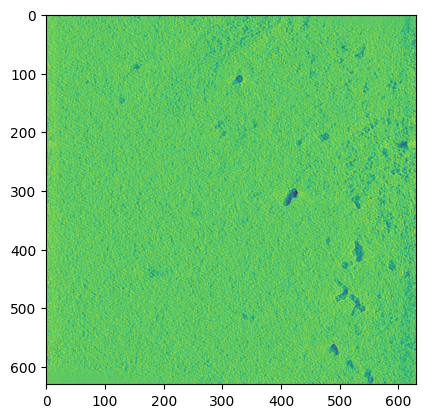

In [36]:
plt.imshow(data_dict['TS_5_4']['denoised'][0][0])

In [37]:
1 <= 2 <= 3

True

In [38]:
valid_labels_df

,id,experiment,particle_type,x,y,z,r,class_id_0,class_id_1,class_id_2,class_id_3,class_id_4,class_id_5
0,0,TS_86_3,apo-ferritin,386.553252,494.655841,126.003199,6.0,1,0,0,0,0,0
1,1,TS_86_3,apo-ferritin,412.576268,541.555278,50.123625,6.0,1,0,0,0,0,0
2,2,TS_86_3,apo-ferritin,273.160065,466.264471,51.964434,6.0,1,0,0,0,0,0
3,3,TS_86_3,apo-ferritin,264.632177,468.478516,60.017613,6.0,1,0,0,0,0,0
4,4,TS_86_3,apo-ferritin,266.204021,480.466198,61.125834,6.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,428,TS_99_9,virus-like-particle,200.755769,474.671110,105.576419,13.5,0,0,0,0,0,1
429,429,TS_99_9,virus-like-particle,224.127883,430.470614,95.835540,13.5,0,0,0,0,0,1
430,430,TS_99_9,virus-like-particle,80.327037,580.990504,57.877276,13.5,0,0,0,0,0,1
431,431,TS_99_9,virus-like-particle,419.300999,552.769922,85.710240,13.5,0,0,0,0,0,1


In [39]:
a = torch.ones(0, 300)
b = torch.ones(2, 300)
c = torch.ones(19, 300)
d = torch.ones(19, 300)
test_pad = pad_sequence([a, b, c, d])
test_pad.size()

torch.Size([19, 4, 300])

In [40]:
def random_rotation_3d(image, bboxes, max_angle=15):
    """
    Randomly rotate the 3D image and adjust bounding sphere coordinates.
    Args:
        image: 3D numpy array (D, H, W)
        bboxes: List of bounding spheres (z, y, x, radius, ...)
        max_angle: Maximum rotation angle in degrees
    Returns:
        Rotated image and adjusted bounding spheres
    """
    angle = np.random.uniform(-max_angle, max_angle)
    
    # Rotate image
    rotated_image = rotate(image, angle, axes=(1, 2), reshape=False, mode='nearest')
    
    # Adjust bounding sphere coordinates
    center = np.array(image.shape) / 2
    rotation_matrix = np.array([
        [np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
        [np.sin(np.radians(angle)), np.cos(np.radians(angle))]
    ])
    
    adjusted_bboxes = []
    for bbox in bboxes:
        z, y, x, radius, *class_vector = bbox
        yx_offset = np.array([y, x]) - center[1:]
        yx_rotated = rotation_matrix @ yx_offset
        y_new, x_new = yx_rotated + center[1:]
        adjusted_bboxes.append([z, y_new, x_new, radius] + class_vector)
    
    return rotated_image, adjusted_bboxes

In [41]:
def random_flip_3d(image, bboxes, axis):
    """
    Randomly flip the 3D image along a specified axis and adjust bounding sphere coordinates.
    Args:
        image: 3D numpy array (D, H, W)
        bboxes: List of bounding spheres (z, y, x, radius, ...)
        axis: Axis to flip (0 for depth, 1 for height, 2 for width)
    Returns:
        Flipped image and adjusted bounding spheres
    """
    flipped_image = np.flip(image, axis=axis)
    
    adjusted_bboxes = []
    for bbox in bboxes:
        z, y, x, radius, *class_vector = bbox
        if axis == 0:
            z = image.shape[0] - z
        elif axis == 1:
            y = image.shape[1] - y
        elif axis == 2:
            x = image.shape[2] - x
        adjusted_bboxes.append([z, y, x, radius] + class_vector)
    
    return flipped_image, adjusted_bboxes

In [42]:
def random_crop_3d(image, bboxes, crop_size=(64, 128, 128)):
    """
    Randomly crop a sub-volume from the 3D image and adjust bounding sphere coordinates.
    Args:
        image: 3D numpy array (D, H, W)
        bboxes: List of bounding spheres (z, y, x, radius, ...)
        crop_size: Size of the cropped volume (D, H, W)
    Returns:
        Cropped image and adjusted bounding spheres
    """
    d, h, w = image.shape
    crop_d, crop_h, crop_w = crop_size
    
    # Ensure the crop size is smaller than the image
    if crop_d > d or crop_h > h or crop_w > w:
        return image, bboxes
    
    # Randomly select the starting point for the crop
    z_start = np.random.randint(0, d - crop_d)
    y_start = np.random.randint(0, h - crop_h)
    x_start = np.random.randint(0, w - crop_w)
    
    # Crop the image
    cropped_image = image[
        z_start:z_start + crop_d,
        y_start:y_start + crop_h,
        x_start:x_start + crop_w
    ]
    
    # Adjust bounding sphere coordinates
    adjusted_bboxes = []
    for bbox in bboxes:
        z, y, x, radius, *class_vector = bbox
        if (z_start <= z < z_start + crop_d and
            y_start <= y < y_start + crop_h and
            x_start <= x < x_start + crop_w):
            adjusted_bboxes.append([
                z - z_start,
                y - y_start,
                x - x_start,
                radius
            ] + class_vector)
    
    return cropped_image, adjusted_bboxes

In [43]:
def add_random_noise(image, noise_std=0.1):
    """
    Add Gaussian noise to the 3D image.
    Args:
        image: 3D numpy array (D, H, W)
        noise_std: Standard deviation of the Gaussian noise
    Returns:
        Noisy image
    """
    noise = np.random.normal(0, noise_std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, image.min(), image.max())

In [44]:
def random_contrast(image, contrast_range=(0.8, 1.2)):
    """
    Randomly adjust the contrast of the 3D image.
    Args:
        image: 3D numpy array (D, H, W)
        contrast_range: Range for contrast adjustment (min, max)
    Returns:
        Contrast-adjusted image
    """
    contrast_factor = np.random.uniform(contrast_range[0], contrast_range[1])
    mean_intensity = np.mean(image)
    adjusted_image = mean_intensity + contrast_factor * (image - mean_intensity)
    return np.clip(adjusted_image, image.min(), image.max())

In [45]:
class DataAugmentation3D:
    def __init__(self, flip=True, rotate=True, gaussian_noise=True, intensity_scaling=True, elastic_deform=True):
        self.flip = flip
        self.rotate = rotate
        self.gaussian_noise = gaussian_noise
        self.intensity_scaling = intensity_scaling
        self.elastic_deform = elastic_deform
        self.alpha = 15
        self.sigma = 3

    def __call__(self, image, labels):
        """
        Apply random 3D data augmentation.
        :param image: 3D numpy array (D, H, W)
        :param labels: Tensor containing bounding spheres (N, 4 + num_classes)
        :return: Augmented image and labels
        """
        if self.flip and random.random() > 0.5:
            image, labels = self.random_flip(image, labels)

        if self.rotate and random.random() > 0.5:
            image, labels = self.random_rotation(image, labels)

        if self.gaussian_noise and random.random() > 0.5:
            image = self.add_gaussian_noise(image)

        if self.intensity_scaling and random.random() > 0.5:
            image = self.scale_intensity(image)

        if self.elastic_deform and random.random() > 0.5:
            image = self.elastic_deformation(image)

        return image, labels

    def random_flip(self, image, labels):
        """ Randomly flip along one or more axes """
        axis = random.choice([0, 1, 2])  # Select a random axis
        image = np.flip(image, axis=axis).copy()

        # Flip bounding spheres accordingly
        labels[:, axis] = image.shape[axis] - labels[:, axis]
        return image, labels

    def random_rotation(self, image, labels):
        """ Apply random 90-degree rotation along a random axis """
        axes = random.choice([(0, 1), (1, 2), (0, 2)])
        k = random.choice([1, 2, 3])  # Rotate 90, 180, or 270 degrees

        image = np.rot90(image, k=k, axes=axes).copy()

        # Rotate bounding spheres
        labels[:, [axes[0], axes[1]]] = labels[:, [axes[1], axes[0]]]
        return image, labels

    def add_gaussian_noise(self, image, mean=0, std=0.01):
        """ Add Gaussian noise to the image """
        noise = np.random.normal(mean, std, image.shape)
        return np.clip(image + noise, 0, 1)  # Keep values between 0-1

    def scale_intensity(self, image, min_scale=0.8, max_scale=1.2):
        """ Scale the intensity of the image randomly """
        scale_factor = random.uniform(min_scale, max_scale)
        return np.clip(image * scale_factor, 0, 1)

    def elastic_deformation(self, image, alpha=15, sigma=3):
        """Apply elastic deformation to a 3D image."""
        if image.ndim != 3:  
            raise ValueError(f"Expected image shape (D, H, W), got {image.shape}")
    
        shape = image.shape  # (D, H, W)
        random_state = np.random.RandomState(None)
    
        # Generate random displacement fields
        dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
        dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
        dz = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    
        # Create meshgrid for indexing
        z, y, x = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    
        # Compute new indices with deformation
        indices = (
            np.clip(z + dz, 0, shape[0] - 1).astype(np.float32),
            np.clip(y + dy, 0, shape[1] - 1).astype(np.float32),
            np.clip(x + dx, 0, shape[2] - 1).astype(np.float32),
        )
    
        # Apply deformation
        return scipy.ndimage.map_coordinates(image, indices, order=1, mode="nearest").reshape(shape)

In [46]:
max_anchors = 0

In [47]:
class YOLO3DDataset_Multi(Dataset):
    def __init__(self, dataset_labels_df, crop_size=(64, 128, 128), stride=(32, 64, 64), transform=None, augment=False):
        self.dataset_labels_df = dataset_labels_df.copy()
        self.crop_size = crop_size
        self.stride = stride
        self.augment = augment
        self.transform = DataAugmentation3D() if augment else None
        
        self.patches = []
        self.patch_bboxes = []
        self.patch_experiment_ids = []
        self.patch_offsets = []  # ✅ Initialize offsets

        self.process_all_images()

    def process_all_images(self):
        """ Process all images and extract patches with corresponding bounding spheres. """
        
        i = 0        
        for experiment in tqdm(self.dataset_labels_df['experiment'].unique()):
            for v in data_dict[experiment].keys():
                image = data_dict[experiment][v]['0']

                # ✅ Ensure consistent normalization
                image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

                image_labels = self.dataset_labels_df[self.dataset_labels_df['experiment'] == experiment].drop(columns=['id']).to_numpy()

                patches, bboxes, offsets = self.create_crops_with_labels(image, image_labels)
                self.patches.extend(patches)
                self.patch_bboxes.extend(bboxes)
                self.patch_experiment_ids.extend([experiment] * len(patches))
                self.patch_offsets.extend(offsets)
                
                i += 1
                
        print(f"✅ Processed {i} images into {len(self.patches)} patches.")

    def create_crops_with_labels(self, image, labels):
        """ Extract overlapping 3D patches and assign bounding spheres to them efficiently. """
        d, h, w = image.shape
        crops, bboxes, offsets = [], [], []
    
        crop_size = self.crop_size
        stride = self.stride

        padding_value = -1 #np.mean(image)  # Use mean intensity for padding

        for z in range(0, d - stride[0], stride[0]):  
            for y in range(0, h - stride[1], stride[1]):  
                for x in range(0, w - stride[2], stride[2]):
                    
                    # ✅ Extract cropped patch
                    cropped_patch = image[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]]

                    # ✅ Apply padding if necessary
                    if cropped_patch.shape != (64, 128, 128):
                        padded_image = np.full((64, 128, 128), padding_value, dtype=image.dtype)
                        padded_image[:cropped_patch.shape[0], :cropped_patch.shape[1], :cropped_patch.shape[2]] = cropped_patch
                        cropped_patch = padded_image.copy()
                        
                    cropped_bboxes = []
    
                    # ✅ Find bounding spheres within this patch (considering partial overlap)
                    for bbox in labels:
                        exp_id, particle_name, x_center, y_center, z_center, radius, *class_vector = bbox

                        # ✅ Compute the nearest stride-aligned grid position
                        z_grid = (z_center // stride[0]) * stride[0]
                        y_grid = (y_center // stride[1]) * stride[1]
                        x_grid = (x_center // stride[2]) * stride[2]
                        
                        # ✅ Assign bounding sphere only once to the closest aligned grid patch
                        #if (z == z_grid and y == y_grid and x == x_grid):
                        if (abs(z_grid - z) < stride[0] and abs(y_grid - y) < stride[1] and abs(x_grid - x) < stride[2]):
                            z_new = z_center - z
                            y_new = y_center - y
                            x_new = x_center - x
                            cropped_bboxes.append([z_new, y_new, x_new, radius] + class_vector)
    
                    # ✅ Append patches and bounding spheres
                    crops.append(torch.tensor(cropped_patch, dtype=torch.float32))
                    bboxes.append(torch.tensor(cropped_bboxes, dtype=torch.float32) if cropped_bboxes else torch.empty((0, 4 + 6)))
                    offsets.append([z, y, x])  # ✅ Store offset for each patch
    
        # ✅ Stack patches into a single tensor for efficient storage
        crops_tensor = torch.stack(crops)
    
        # ✅ Pad bounding sphere tensors for batch consistency
        bboxes_tensor = pad_sequence(bboxes, batch_first=True, padding_value=-1)

        #print(bboxes_tensor.shape)

        offsets_tensor = torch.tensor(offsets, dtype=torch.float32)
    
        return crops_tensor, bboxes_tensor, offsets_tensor

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x = self.patches[idx]  # Shape: (64, 128, 128)
        y = self.patch_bboxes[idx]
        experiment_id = self.patch_experiment_ids[idx]
        crop_offset = self.patch_offsets[idx]
    
        # ✅ Ensure image is in (D, H, W) format before augmentation
        if x.ndim == 4 and x.shape[0] == 1:  
            x = x.squeeze(0)  # Remove the channel dimension if it exists
    
        # ✅ Apply Data Augmentation if Enabled
        if self.augment and self.transform:
            x, y = self.transform(x.numpy(), y)  # Convert to numpy for augmentation
            x = torch.tensor(x, dtype=torch.float32)  # Convert back to tensor
    
        # ✅ Restore (1, D, H, W) format before returning
        return x.unsqueeze(0), y, experiment_id, crop_offset

In [48]:
# ✅ Example Usage
train_dataset = YOLO3DDataset_Multi(train_labels_df, augment=True)

100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.89s/it]

✅ Processed 20 images into 8100 patches.


In [49]:
valid_dataset = YOLO3DDataset_Multi(valid_labels_df)

100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.31s/it]

✅ Processed 8 images into 3240 patches.


In [50]:
def collate_fn(batch):
    images, targets, experiment_ids, crop_offsets = zip(*batch)

    # 🔹 Find the maximum depth, height, and width across the batch
    max_d = max(img.shape[1] for img in images)  # Depth
    max_h = max(img.shape[2] for img in images)  # Height
    max_w = max(img.shape[3] for img in images)  # Width

    # 🔹 Pad images to the largest shape in the batch
    padded_images = []
    for img in images:
        d, h, w = img.shape[1:]  # Extract original shape
        pad_img = torch.full((1, max_d, max_h, max_w), fill_value=-1.0, dtype=img.dtype)
        pad_img[:, :d, :h, :w] = img  # Copy original data
        padded_images.append(pad_img)

    images = torch.stack(padded_images, dim=0)  # Stack into batch tensor

    # 🔹 Handle bounding box padding
    max_boxes = max(target.shape[0] for target in targets)  # Find max anchor count
    padded_targets = torch.full((len(targets), max_boxes, 10), -1.0)  # Use -1 as padding
    for i, target in enumerate(targets):
        padded_targets[i, :target.shape[0], :] = target  # Copy values

    # ✅ **Fix: Ensure `crop_offsets` are stacked properly**
    if isinstance(crop_offsets[0], torch.Tensor):
        crop_offsets_tensor = torch.stack(crop_offsets)  # Already tensors, just stack
    else:
        crop_offsets_tensor = torch.tensor(crop_offsets, dtype=torch.float32)  # Convert list to tensor

    return images, padded_targets, list(experiment_ids), crop_offsets_tensor

In [51]:
def count_anchors_in_patch(targets):
    """
    Counts the number of valid bounding spheres (anchors) per cropped image.
    Only considers valid targets where x != -1.
    """
    num_anchors = (targets[..., 0] != -1).sum().item()  # Count valid bounding spheres
    return num_anchors

In [52]:
def find_max_anchors_dataloader(dataset, batch_size=8, num_workers=4):
    """
    Finds the maximum number of anchors per cropped image in the dataset.
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    max_anchors = 0
    for batch in tqdm(dataloader, total=len(dataloader)):
        _, targets, _, _ = batch  # Unpack batch
        for i in range(targets.shape[0]):  # Iterate over cropped images in batch
            num_anchors = count_anchors_in_patch(targets[i])  # Count per patch
            max_anchors = max(max_anchors, num_anchors)  # Track highest per patch

    return max_anchors

In [53]:
max_anchors = find_max_anchors_dataloader(train_dataset, batch_size=32, num_workers=6)
print(f"Optimal Number of Anchors per Cropped Image: {max_anchors}")

100%|█████████████████████████████████████████| 254/254 [04:15<00:00,  1.01s/it]

Optimal Number of Anchors per Cropped Image: 15


In [54]:
#max_anchors = 34

In [55]:
#val_max_anchors = find_max_anchors(valid_dataset)
#val_max_anchors

In [76]:
class YOLO3D_MedicalNet(nn.Module):
    def __init__(self, num_classes=6, num_anchors=5, pretrain_path=None):
        super(YOLO3D_MedicalNet, self).__init__()

        self.backbone = resnet.resnet18(
            sample_input_W=128,
            sample_input_H=128,
            sample_input_D=64,
            shortcut_type='B',
            no_cuda=False,
            num_seg_classes=num_classes
        )

        if pretrain_path:
            print(f"✅ Loading Pretrained MedicalNet Weights from: {pretrain_path}")
            pretrain = torch.load(pretrain_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
            self.backbone.load_state_dict(pretrain['state_dict'], strict=False)

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # ✅ Compute Feature Size Dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 64, 128, 128)
            dummy_output = self.backbone(dummy_input)
            dummy_output = F.adaptive_avg_pool3d(dummy_output, (16, 32, 32))  # Fix depth to 16
            print(f"✅ Backbone Output Shape: {dummy_output.shape}")  
            self.feature_map_size = dummy_output.shape[2:]  
            self.feature_depth = dummy_output.shape[1]  

        # ✅ Ensure depth=16 in conv1x1x1
        self.conv1x1x1 = nn.Sequential(
            nn.Conv3d(self.feature_depth, 16, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(16),
            nn.ReLU()
        )

        # ✅ Compute fc input size dynamically
        flattened_feature_size = 16 * self.feature_map_size[0] * self.feature_map_size[1] * self.feature_map_size[2]
        print(f"✅ Expected fc input size: {flattened_feature_size}") 

        self.fc = nn.Linear(flattened_feature_size, self.num_anchors * (4 + self.num_classes))

    def forward(self, x):
        x = self.backbone(x)
        x = F.adaptive_avg_pool3d(x, (16, 32, 32))  # Force depth to 16
        #print(f"After Adaptive Pooling: {x.shape}") 

        x = self.conv1x1x1(x)
        #print(f"After conv1x1x1: {x.shape}")

        x = x.view(x.shape[0], -1)

        # Dynamically update fc layer if shape mismatch occurs
        if self.fc.in_features != x.shape[1]:
            print(f"⚠️ Updating fc layer: New Input Size {x.shape[1]} (Old: {self.fc.in_features})")
            self.fc = nn.Linear(x.shape[1], self.num_anchors * (4 + self.num_classes)).to(x.device)

        #print(f"Before fc: {x.shape}") 

        x = self.fc(x)

        batch_size = x.shape[0]
        x = x.view(batch_size, self.num_anchors, 4 + self.num_classes)

        x_class = torch.softmax(x[..., 4:], dim=-1)
        x = torch.cat([x[..., :4], x_class], dim=-1)

        return x

In [77]:
model = YOLO3D_MedicalNet(num_anchors=max_anchors, pretrain_path="/home/max1024/models/MedicalNet/resnet_18_23dataset.pth")

/home/max1024/projects/MedicalNet/models/resnet.py:173: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
/tmp/ipykernel_15876/552143444.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don'

✅ Loading Pretrained MedicalNet Weights from: /home/max1024/models/MedicalNet/resnet_18_23dataset.pth
✅ Backbone Output Shape: torch.Size([1, 6, 16, 32, 32])
✅ Expected fc input size: 262144


In [78]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, predictions, targets):
        """Compute focal loss across all anchors."""

        # ✅ Adjust for Multiple Anchors: Shape (batch_size, num_anchors, 4 + num_classes)
        pred_cls = predictions[..., 4:].clone()  # Extract class predictions
        target_cls = targets[..., 4:].clone()  # Extract target class labels

        pred_cls = torch.clamp(pred_cls, min=-20, max=20)  # Prevent instability
        target_cls = torch.clamp(target_cls, min=0, max=1)

        ce_loss = F.binary_cross_entropy_with_logits(pred_cls, target_cls, reduction="none")

        # Compute focal weight
        p_t = torch.exp(-ce_loss)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss

        # 🔹 Reduce Focal Loss weight to allow learning
        focal_loss *= 0.5  

        # ✅ Average across anchors
        focal_loss = focal_loss.mean(dim=1)  # Average over `num_anchors`

        # ✅ Apply per-class weights
        if self.alpha is not None:
            focal_loss *= self.alpha.to(predictions.device)

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class SoftFBetaLoss(nn.Module):
    def __init__(self, beta=4, eps=1e-6, alpha=None):
        super(SoftFBetaLoss, self).__init__()
        self.beta = beta
        self.eps = eps
        self.alpha = alpha  # Class weights

    def forward(self, predictions, targets):
        """Compute F-beta loss across multiple anchors."""

        # ✅ Ensure Predictions and Targets have the same number of anchors
        min_size = min(predictions.shape[1], targets.shape[1])  # Align sizes
        predictions = predictions[:, :min_size, :].clone()
        targets = targets[:, :min_size, :].clone()

        target_cls = targets[..., 4:]
        pred_cls = predictions[..., 4:]

        pred_cls = torch.clamp(pred_cls, min=-10, max=10)  
        pred_cls = torch.sigmoid(pred_cls)  

        # Compute Precision and Recall
        tp = torch.sum(pred_cls * target_cls, dim=0)
        fp = torch.sum(pred_cls * (1 - target_cls), dim=0)
        fn = torch.sum((1 - pred_cls) * target_cls, dim=0)

        # ✅ Fix: Use `.sum()` instead of direct comparison
        tp_fp_sum = tp + fp
        tp_fn_sum = tp + fn

        precision = tp / (tp_fp_sum + self.eps)  
        recall = tp / (tp_fn_sum + self.eps)  

        fbeta = (1 + self.beta ** 2) * precision * recall / ((self.beta ** 2) * precision + recall + self.eps)

        if self.alpha is not None:
            fbeta *= self.alpha.to(pred_cls.device)

        return 1 - fbeta.mean()

class RegressionLoss(nn.Module):
    def __init__(self, reduction="mean"):
        super(RegressionLoss, self).__init__()
        self.smooth_l1 = nn.SmoothL1Loss(reduction=reduction)

    def forward(self, predictions, targets):
        pred_reg = predictions[..., :4]
        target_reg = targets[..., :4]

        # Normalize regression targets (avoid large-scale errors)
        max_range = 128.0  # Adjust based on dataset scale
        pred_reg /= max_range
        target_reg /= max_range

        # Compute Smooth L1 loss
        reg_loss = self.smooth_l1(pred_reg, target_reg)

        # ✅ Ensure correct reduction
        if reg_loss.dim() > 1:
            reg_loss = reg_loss.mean(dim=-1)  # Average across outputs (x, y, z, r)

        return reg_loss.mean() if self.smooth_l1.reduction == "mean" else reg_loss.sum()


class CombinedLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, beta=4, lambda_focal=0.5, lambda_fbeta=0.5, lambda_reg=0.5):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.fbeta_loss = SoftFBetaLoss(beta=beta, alpha=alpha)
        self.regression_loss = RegressionLoss()

        self.lambda_focal = lambda_focal
        self.lambda_fbeta = lambda_fbeta
        self.lambda_reg = lambda_reg  # New term for regression loss

    def forward(self, predictions, targets):
        """Compute combined loss over multiple anchors."""

        focal = self.focal_loss(predictions, targets)
        fbeta = self.fbeta_loss(predictions, targets)
        reg_loss = self.regression_loss(predictions, targets)

        total_loss = self.lambda_focal * focal + self.lambda_fbeta * fbeta + self.lambda_reg * reg_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"❌ NaN/Inf detected in loss function! Focal Loss: {focal}, F_beta Loss: {fbeta}, Regression Loss: {reg_loss}")

        return total_loss

In [79]:
# ✅ Initialize Loss Function
loss_fn = CombinedLoss(alpha=class_weights, lambda_focal=0.5, lambda_fbeta=0.5, lambda_reg=0.5)
#loss_fn = CombinedLoss(lambda_focal=0.5, lambda_fbeta=0.5, lambda_reg=0.5)

In [80]:
'''
def collate_fn(batch):
    images, targets, experiment_ids, crop_offsets = zip(*batch)  
    images = torch.stack(images, dim=0)  # Stack images into a batch tensor

    max_boxes = max(target.shape[0] for target in targets)

    padded_targets = torch.full((len(targets), max_boxes, 10), -1.0)  # Use -1 for padding
    for i, target in enumerate(targets):
        padded_targets[i, :target.shape[0], :] = target  # Copy actual values

    # ✅ Fix: Avoid redundant tensor conversion
    if isinstance(crop_offsets[0], torch.Tensor):  
        crop_offsets_tensor = torch.stack(crop_offsets)  # Already tensors, just stack
    else:
        crop_offsets_tensor = torch.stack([offset.clone().detach() for offset in crop_offsets])

    return images, padded_targets, list(experiment_ids), crop_offsets_tensor
'''

'\ndef collate_fn(batch):\n    images, targets, experiment_ids, crop_offsets = zip(*batch)  \n    images = torch.stack(images, dim=0)  # Stack images into a batch tensor\n\n    max_boxes = max(target.shape[0] for target in targets)\n\n    padded_targets = torch.full((len(targets), max_boxes, 10), -1.0)  # Use -1 for padding\n    for i, target in enumerate(targets):\n        padded_targets[i, :target.shape[0], :] = target  # Copy actual values\n\n    # ✅ Fix: Avoid redundant tensor conversion\n    if isinstance(crop_offsets[0], torch.Tensor):  \n        crop_offsets_tensor = torch.stack(crop_offsets)  # Already tensors, just stack\n    else:\n        crop_offsets_tensor = torch.stack([offset.clone().detach() for offset in crop_offsets])\n\n    return images, padded_targets, list(experiment_ids), crop_offsets_tensor\n'

In [81]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8,  # ✅ Increase batch size for efficiency
    shuffle=True,  
    num_workers=8,  # ✅ Start with 2, increase if stable
    pin_memory=True,  # ✅ Optimizes GPU memory transfer
    collate_fn=collate_fn,
    persistent_workers=True
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=8,  # ✅ Keep batch size consistent
    shuffle=False,  # ✅ No need for shuffling in validation
    num_workers=8,  # ✅ Start with a low value
    pin_memory=True,  
    collate_fn=collate_fn,
    persistent_workers=True
)

In [82]:
def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [83]:
def extract_predictions(predictions, experiment_ids, crop_offsets, threshold=0.2):
    pred_list = []
    particle_classes = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

    #print(f"🚨 Debug: Predictions shape: {predictions.shape}")  # Should be (batch, num_anchors, 10)
    #print(f"🚨 Debug: Experiment IDs: {experiment_ids}")

    for i in range(len(predictions)):  # Loop over batch
        pred_batch = predictions[i].detach().cpu()  # (num_anchors, 10)

        #print(f"🚨 Debug: Batch {i} predictions shape: {pred_batch.shape}")  # Check anchor count

        experiment_id = experiment_ids[i]
        offset_z, offset_y, offset_x = map(float, crop_offsets[i])  # ✅ Convert offsets to floats

        # ✅ Loop over anchors within this batch item
        for anchor_idx in range(pred_batch.shape[0]):  
            pred = pred_batch[anchor_idx]  # Extract anchor predictions

            # ✅ Convert relative coordinates to absolute
            x_pred = pred[2] + offset_x
            y_pred = pred[1] + offset_y
            z_pred = pred[0] + offset_z
            radius = pred[3]

            # ✅ Extract class probabilities and ensure validity
            class_probs = pred[4:].numpy()

            #print(class_probs.shape)

            if class_probs.size == 0:
                print(f"⚠️ Skipping anchor {anchor_idx} due to missing class probabilities!")
                continue
            
            #print(f"🚨 Debug: Anchor {anchor_idx} class_probs shape: {class_probs.shape}")

            if len(class_probs) != len(particle_classes):
                print(f"⚠️ Warning: class_probs shape mismatch. Expected {len(particle_classes)}, got {len(class_probs)}.")
                print(predictions.shape)
                continue  # Skip this anchor

            class_id = np.argmax(class_probs)
            confidence = np.max(class_probs)

            # ✅ Ensure `class_id` is within range
            if 0 <= class_id < len(particle_classes) and confidence > threshold:
                particle_type = particle_classes[class_id]

                # ✅ Store as DataFrame
                pred_df = pd.DataFrame({
                    "experiment": [experiment_id],
                    "particle_type": [particle_type],
                    "x": [x_pred],
                    "y": [y_pred],
                    "z": [z_pred]
                })
                pred_list.append(pred_df)

    return pd.concat(pred_list, ignore_index=True) if pred_list else pd.DataFrame()

In [84]:
def train_yolo3d_medicalnet(
    model, 
    train_dataloader, 
    val_dataloader,  
    loss_fn, 
    epochs=5, 
    lr=3e-3,
    fine_tune=True, 
    beta=4,  
    distance_multiplier=1.0,
    backbone_lr=5e-4
):
    """
    Trains YOLO3D with multiple anchors instead of a single bounding sphere per image.
    Uses validation set and computes `F_beta` score for competition ranking.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = torch.compile(model)
    
    # Enable TensorFloat32 acceleration (for NVIDIA Ampere+ GPUs)
    torch.set_float32_matmul_precision('high')  

    # Mixed Precision Components
    scaler = torch.amp.GradScaler()  
    autocast_dtype = torch.float16  # Use FP16 for mixed precision
    
    optimizer = torch.optim.Adam([
        {"params": model.backbone.parameters(), "lr": backbone_lr},
        {"params": [p for n, p in model.named_parameters() if "backbone" not in n], "lr": lr}
    ]) 

    best_fbeta = 0  
    best_model_state = None  
    best_epoch = 0

    print(f"🚀 Training on {device} | Mixed Precision: Enabled")
    print(f"📝 Fine-tuning: {fine_tune} | Backbone LR: {backbone_lr} | New Layers LR: {lr}")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for batch_idx, (x, y, experiment_ids, crop_offsets) in enumerate(train_dataloader):
            if x is None:  
                continue
                
            x = x.to(device, dtype=torch.float32, non_blocking=True)
            y = y.to(device, dtype=torch.float32, non_blocking=True)

            if torch.isnan(y).any() or torch.isinf(y).any():
                print(f"❌ NaN/Inf detected in labels at epoch {epoch}, batch {batch_idx}")
                print(f"🛠️ Labels Stats - Min: {y.min()}, Max: {y.max()}")
                continue  

            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):  
                predictions = model(x)

                #extract_predictions(predictions, experiment_ids, crop_offsets)

                # **✅ Ensure loss handles multiple anchors**
                num_anchors = predictions.shape[1]

                # **✅ Ensure padding aligns properly**
                max_size = max(predictions.shape[1], y.shape[1])
                padded_predictions = torch.full((predictions.shape[0], max_size, predictions.shape[2]), -1.0, device=predictions.device)
                padded_targets = torch.full((y.shape[0], max_size, y.shape[2]), -1.0, device=y.device)
                
                # Copy actual values
                padded_predictions[:, :predictions.shape[1], :] = predictions
                padded_targets[:, :y.shape[1], :] = y

                loss = loss_fn(padded_predictions, padded_targets)

            scaler.scale(loss).backward()  
            scaler.step(optimizer)  
            scaler.update()  

            total_train_loss += loss.item()

        # **🔹 Run Validation**
        model.eval()
        total_val_loss = 0.0
        val_preds, val_gts = [], []

        with torch.no_grad():
            for batch_idx, (x, y, experiment_ids, crop_offsets) in enumerate(val_dataloader):
                x = x.to(device, dtype=torch.float32, non_blocking=True)
                y = y.to(device, dtype=torch.float32, non_blocking=True)

                with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):  
                    predictions = model(x)

                    # **✅ Ensure loss accounts for multiple anchors**
                    num_anchors = predictions.shape[1]
                    max_size = max(predictions.shape[1], y.shape[1])  

                    # **✅ Padding to ensure correct loss computation**
                    padded_predictions = torch.full((predictions.shape[0], max_size, predictions.shape[2]), -1.0, device=predictions.device)
                    padded_targets = torch.full((y.shape[0], max_size, y.shape[2]), -1.0, device=y.device)
                    
                    # Copy actual values
                    padded_predictions[:, :predictions.shape[1], :] = predictions
                    padded_targets[:, :y.shape[1], :] = y

                    val_loss = loss_fn(padded_predictions, padded_targets)
                    total_val_loss += val_loss.item()

                    # **✅ Extract Predictions Per Anchor**
                    val_preds.append(extract_predictions(predictions, experiment_ids, crop_offsets))  

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)

        # **🔹 Compute F_beta score**
        submission_df = pd.concat(val_preds, ignore_index=True).drop_duplicates(
            subset=['experiment', 'particle_type', 'x', 'y', 'z']
        ).sort_values(by=['experiment', 'particle_type']).reset_index(drop=True).reset_index().rename(
            columns={'index': 'id'}
        ) if val_preds else pd.DataFrame()
        
        val_fbeta = score(valid_labels_df[['id', 'experiment', 'particle_type', 'x', 'y', 'z']], submission_df, "id", 0.1, 4) if not submission_df.empty else 0.0

        # **🔹 Track Best Model Based on Validation F_beta Score**
        if val_fbeta > best_fbeta:
            best_fbeta = val_fbeta
            best_model_state = copy.deepcopy(model)  
            best_epoch = epoch
            torch.save(best_model_state, f"best_yolo3d_model_{best_fbeta:.4f}.pth")
            print(f"💾 Best Model Saved with F_beta: {best_fbeta:.4f}")

        print(f"✅ Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | 📊 Val F_beta: {val_fbeta:.4f} | Best Epoch: {best_epoch+1} | Best Val F_beta: {best_fbeta:.4f}")

    print("🎯 Training Complete!")

In [85]:
# ✅ Run training
train_yolo3d_medicalnet(model, train_loader, valid_loader, loss_fn, epochs=200, lr=3e-3, fine_tune=True)

🚀 Training on cuda | Mixed Precision: Enabled
📝 Fine-tuning: True | Backbone LR: 0.0005 | New Layers LR: 0.003
💾 Best Model Saved with F_beta: 0.0126
✅ Epoch [1/200] | Train Loss: 0.241417 | Val Loss: 0.231639 | 📊 Val F_beta: 0.0126 | Best Epoch: 1 | Best Val F_beta: 0.0126
✅ Epoch [2/200] | Train Loss: 0.233497 | Val Loss: 0.217280 | 📊 Val F_beta: 0.0078 | Best Epoch: 1 | Best Val F_beta: 0.0126
✅ Epoch [3/200] | Train Loss: 0.227513 | Val Loss: 0.217246 | 📊 Val F_beta: 0.0085 | Best Epoch: 1 | Best Val F_beta: 0.0126


Exception in thread Thread-11 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/local/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/max1024/venvs/ml

KeyboardInterrupt: 

# References

1. https://www.kaggle.com/code/davidlist/experiment-ts-6-4-visualization
2. https://www.kaggle.com/code/nk35jk/3d-visualization-of-particles